# Initialization

Test notebook for the C-MAPPS benchmark. Approach using MLP. 

First we import the necessary packages and create the global variables.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib
import seaborn as sns
import pandas as pd
import time

import CMAPSAuxFunctions
#import plottingTools
#from datetime import datetime
#from sklearn.covariance import EllipticEnvelope
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.dummy import DummyClassifier
#from sklearn.model_selection import train_test_split, cross_validate
#from sklearn.neural_network import MLPClassifier
#from mpl_toolkits.mplot3d import Axes3D
#from dataManagement import DataManagerDamadics
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Reshape, Conv2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from IPython.display import display, HTML
%matplotlib notebook

global constRUL

constRUL = 125
time_window = 30
rul_vector = None
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Retrieve and Reshape data

Get the data from the text files, store it in a Pandas Dataframe and reshape it as appropiately.

In [7]:
data_file_train = '../CMAPSSData/train_FD001.txt'
data_file_test = '../CMAPSSData/test_FD001.txt'

#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
standardScaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

#Selected as per CNN paper
selected_features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'htBleed', 'W31', 'W32']

nFeatures = len(selected_features)

#Get the X and y matrices with the specified time window
X_train, y_train, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_train, selected_features, time_window, 'train')
X_test, _, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 'test')

#Standardize the data
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

#Retrieve the data as Xiang

#X_train, y_train, min_max_scaler = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_train, selected_features, 
#                                                               time_window, 'train', scaler=min_max_scaler)

#X_test, _ , _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, 
#                                                        time_window, 'test', scaler=min_max_scaler, fit_transform=False)

y_test = np.loadtxt("../CMAPSSData/RUL_FD001.txt")
y_test = np.array([x if x < constRUL else constRUL for x in y_test])
y_test = np.reshape(y_test, (y_test.shape[0], 1))

#Create samples and labels matrices to be used with the CNN
samples = np.reshape(X_train, newshape=(X_train.shape[0], time_window, int(X_train.shape[1]/time_window)))
samplet = np.reshape(X_test, newshape=(X_test.shape[0], time_window, int(X_test.shape[1]/time_window)))
targets = np.reshape(y_train, newshape=(y_train.shape[0], -1))
labelt = np.reshape(y_test, newshape=(y_test.shape[0], -1))

In [8]:
print("Training data (X, y)")
print(X_train.shape)
print(y_train.shape)
print("Testing data (X, y)")
print(X_test.shape)
print(y_test.shape)

'''
print("Training data (samples, targets)")
print(samples.shape)
print(targets.shape)
print("Testing data (samples, targets)")
print(samplet.shape)
print(labelt.shape)
'''

print("Training data (X, y)")
print(X_train[:5,:])
print(y_train[:5,:])
print("Testing data (X, y)")
print(X_test[:5,:])
print(y_test[:5,:])

'''
print("Training data (samples, targets)")
print(samples[:5,:])
print(targets[:5])
print("Testing data (samples, targets)")
print(samplet[:5,:])
print(labelt[:5])

print("Training data (X, y)")
print(X_train[-5:,:])
print(y_train[-5:,:])
print("Testing data (X, y)")
print(X_test[-5:,:])
print(y_test[-5:,:])

print("Training data (samples, targets)")
print(samples[-5:,:])
print(targets[-5:])
print("Testing data (samples, targets)")
print(samplet[-5:,:])
print(labelt[-5:])
'''

Training data (X, y)
(17731, 420)
(17731, 1)
Testing data (X, y)
(100, 420)
(100, 1)
Training data (X, y)
[[-0.58075601 -0.0455243  -0.27982732 ... -0.81818182  0.43307087
   0.4679733 ]
 [-0.35395189  0.0629156  -0.18014129 ... -0.45454545  0.25984252
   0.25294702]
 [-0.21649485 -0.13299233 -0.13854003 ... -0.45454545  0.38582677
   0.72049425]
 [-0.21649485 -0.39897698 -0.2299843  ... -0.45454545  0.08661417
   0.29640676]
 [-0.20274914 -0.39590793 -0.05926217 ... -0.45454545  0.05511811
   0.17880983]]
[[125.]
 [125.]
 [125.]
 [125.]
 [125.]]
Testing data (X, y)
[[-0.65635739 -0.10946292 -0.48312402 ... -0.27272727  0.05511811
   0.30947309]
 [ 0.03780069 -0.07365729 -0.27629513 ... -0.63636364  0.05511811
   0.04416986]
 [ 0.13402062 -0.08644501  0.038854   ...  0.09090909  0.24409449
   0.07882403]
 [-0.14776632  0.16828645  0.00431711 ...  0.09090909 -0.30708661
   0.03365999]
 [-0.05841924  0.24654731  0.04317111 ... -0.09090909 -0.03937008
   0.46996165]]
[[112.]
 [ 98.]
 [ 69

'\nprint("Training data (samples, targets)")\nprint(samples[:5,:])\nprint(targets[:5])\nprint("Testing data (samples, targets)")\nprint(samplet[:5,:])\nprint(labelt[:5])\n\nprint("Training data (X, y)")\nprint(X_train[-5:,:])\nprint(y_train[-5:,:])\nprint("Testing data (X, y)")\nprint(X_test[-5:,:])\nprint(y_test[-5:,:])\n\nprint("Training data (samples, targets)")\nprint(samples[-5:,:])\nprint(targets[-5:])\nprint("Testing data (samples, targets)")\nprint(samplet[-5:,:])\nprint(labelt[-5:])\n'

# Keras model

We will use a very simple ANN for this example. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

In [4]:
def RULmodel(input_shape):
    
    print(input_shape)
    
    #Create a sequential model
    model = Sequential()
    
    #Add the layers for the model
    model.add(Dense(500, input_dim=input_shape, activation='relu', kernel_initializer='glorot_normal', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu', kernel_initializer='glorot_normal', name='fc2'))
    model.add(Dropout(0.5))
    #model.add(Dense(100, activation='tanh', name='fc3'))
    #model.add(Dropout(0.5))
    #model.add(Dense(10, activation='tanh', name='fc4'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', name='out'))
    
    #create a placeholder for the input
    #X_input = Input(shape=(input_shape))
    
    #Create the layers
    #X = Dense(100, activation='relu', name='fc1')(X_input)
    #X = Dense(100, activation='relu', name='fc2')(X)
    #X = Dense(1, activation='linear', name='out')(X)
    
    # Create model. This creates the Keras model instance, you'll use this instance to train/test the model.
    #model = Sequential(inputs = X_input, outputs = X, name='RUL')
    
    return model

# Fit the keras model
Fit the Keras model to the data and determine its performance.

In [9]:
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)
opt = Adam(lr=0, beta_1=0.5)

#Create the model
modelRUL = RULmodel(X_train.shape[1])

#Compile the model.
modelRUL.compile(optimizer = opt, loss = "mean_squared_error", metrics = ["mse"])

startTime = time.clock()
#Train the model.
modelRUL.fit(x = X_train, y = y_train, epochs = 250, batch_size = 512, callbacks=[lrate])  
endTime = time.clock()

420
Epoch 1/250
17731/17731 [==============================] - 0s 14us/step - loss: 2797.1493 - mean_squared_error: 2797.1493
Epoch 2/250
17731/17731 [==============================] - 0s 10us/step - loss: 505.0097 - mean_squared_error: 505.0097
Epoch 3/250
17731/17731 [==============================] - 0s 9us/step - loss: 425.9310 - mean_squared_error: 425.9310
Epoch 4/250
17731/17731 [==============================] - 0s 9us/step - loss: 387.7854 - mean_squared_error: 387.7854
Epoch 5/250
17731/17731 [==============================] - 0s 10us/step - loss: 379.9497 - mean_squared_error: 379.9497
Epoch 6/250
17731/17731 [==============================] - 0s 9us/step - loss: 369.7126 - mean_squared_error: 369.7126
Epoch 7/250
17731/17731 [==============================] - 0s 9us/step - loss: 368.0221 - mean_squared_error: 368.0221
Epoch 8/250
17731/17731 [==============================] - 0s 9us/step - loss: 364.9547 - mean_squared_error: 364.9547
Epoch 9/250
17731/17731 [==============

Epoch 137/250
17731/17731 [==============================] - 0s 9us/step - loss: 259.9122 - mean_squared_error: 259.9122
Epoch 138/250
17731/17731 [==============================] - 0s 9us/step - loss: 262.1586 - mean_squared_error: 262.1586
Epoch 139/250
17731/17731 [==============================] - 0s 9us/step - loss: 269.4982 - mean_squared_error: 269.4982
Epoch 140/250
17731/17731 [==============================] - 0s 10us/step - loss: 267.6635 - mean_squared_error: 267.6635
Epoch 141/250
17731/17731 [==============================] - 0s 9us/step - loss: 259.9855 - mean_squared_error: 259.9855
Epoch 142/250
17731/17731 [==============================] - 0s 9us/step - loss: 258.5901 - mean_squared_error: 258.5901
Epoch 143/250
17731/17731 [==============================] - 0s 9us/step - loss: 259.7486 - mean_squared_error: 259.7486
Epoch 144/250
17731/17731 [==============================] - 0s 9us/step - loss: 260.4655 - mean_squared_error: 260.4655
Epoch 145/250
17731/17731 [====

In [10]:
#Evaluate the model
score = modelRUL.evaluate(x = X_test, y = y_test)
y_pred = modelRUL.predict(X_test)
healtScore = CMAPSAuxFunctions.compute_health_score(y_test, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score[0])))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 431us/step
Root Square Mean Error score: 13.892881950275017
Health score: [363.08111614]
Elapsed time: 41.70623547505292


# CNN Model
Fit the Keras model to the data using a CNN and determine its performance.

# Initialization

# Constants

# Reshape data to fit a convNet

# Keras model

CNN model. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

# Fit the keras model

Fit the Keras model to the data and determine its performance.

In [45]:
def plotRUL(cycles, rulArray, nnPred, cnnPred, engineUnit):
    
    plt.clf()
    plt.plot(cycles, rulArray, 'bo-', label='RUL')
    plt.plot(cycles, nnPred, 'go-', label='NN Pred')
    plt.plot(cycles, cnnPred, 'ro-', label='CNN Pred')
    plt.legend()
    plt.xlabel("Time (Cycle)")
    plt.ylabel("RUL")
    plt.title("Test Engine Unit #{}".format(engineUnit))
    plt.show()

<IPython.core.display.Javascript object>


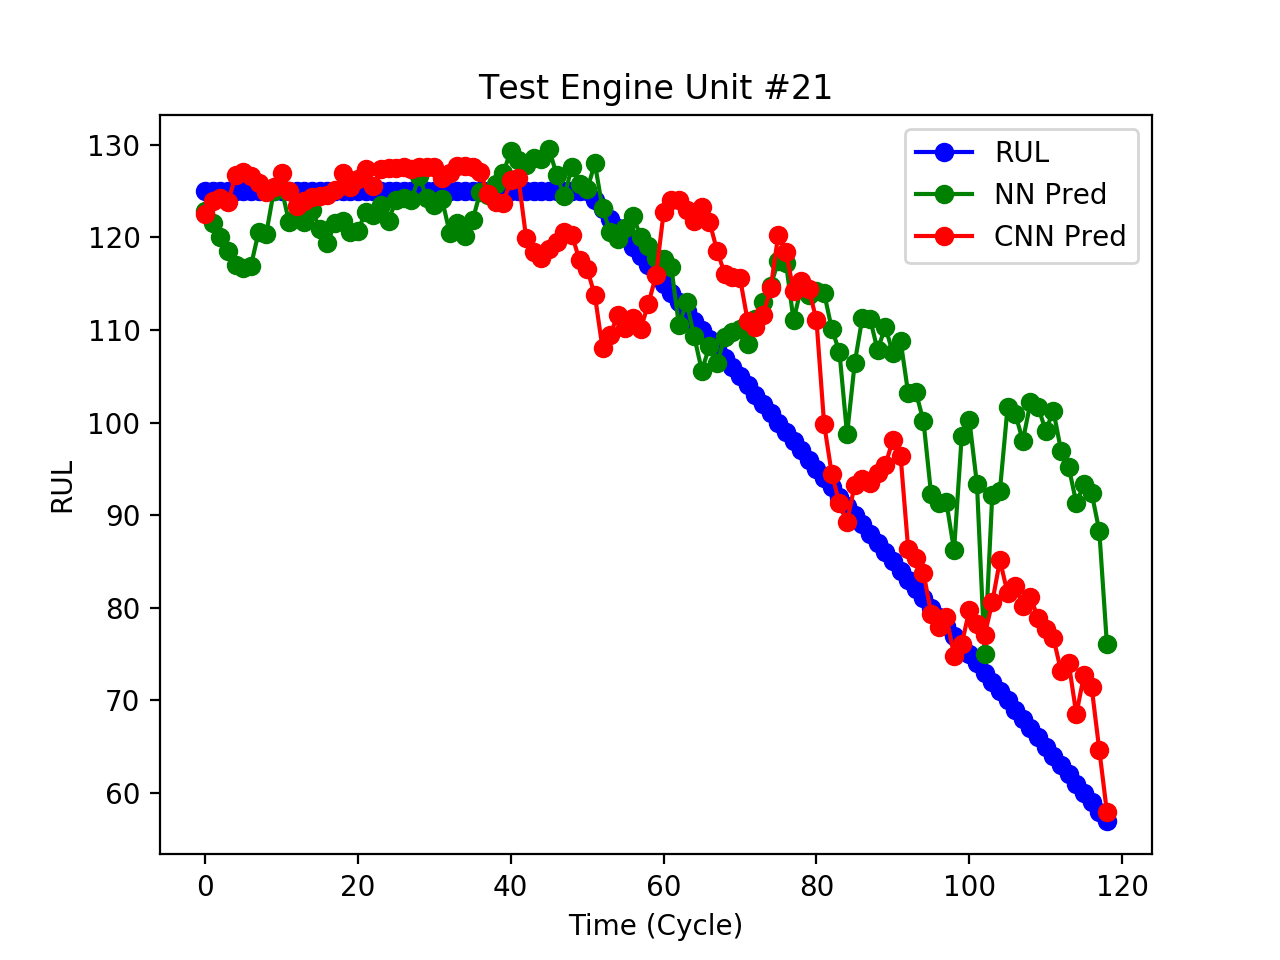

In [46]:
engineUnit = 21

X_test2, _, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 
                                                             'train', scaler=min_max_scaler, fit_transform=False, unit_number=engineUnit)
#X_test2, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 'train', unit_number=engineUnit)
#X_test2 = min_max_scaler.fit_transform(X_test2)

samplet2 = np.reshape(X_test2, newshape=(X_test2.shape[0], int(X_test2.shape[1]/nFeatures), nFeatures))

nnPred = modelRUL.predict(X_test2)
cnnPred = DCNN.predict(samplet2)

maxCycle = X_test2.shape[0]
faultCycle = y_test[engineUnit-1]
cycles = np.arange(maxCycle)
rulArray = np.arange(faultCycle, maxCycle+faultCycle)
rulArray[rulArray > constRUL] = constRUL
rulArray = np.flipud(rulArray)

#print(cycles)
#print(rulArray)

'''print("Testing data")
print(X_test2.shape)
print(X_test2[-5:,:])
print(nnPred)
print(cnnPred)'''

plotRUL(cycles, rulArray, nnPred, cnnPred, engineUnit)